### Data Generation
This notebook generates training and testing data for the deep learning CW decoder. Generated data possesses statictical properties of the real-world messages found on the HF Ham bands, such as the relative frequencies of occurrence of different characters, word lengths, variations in the dot and dash lengths, noise statistics and Rayleigh fading. Different keying styles are supported, including hand keyed Morse Code, Vibroplex, Iambic keyer, and computer-generated CW.

The data are generated in the form of spectrograms, 2-D arrays of magnitudes similar to the waterfall displays in the SDR software. The format of the data is compatible with TensorFlow API.

While generated data may be saved to a file, the generator is fast enough to produce data on the fly, using the `MorseDataGenerator` class. The notebook pages saves all code required for data generation in the Python files located in the `data_generation` subfolder.

In [1]:
import time
from scipy.optimize import curve_fit
from numpy.random import default_rng
from scipy import signal
import tensorflow
import math
import numpy as np
# import librosa
# import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import my_paths

# auto reload changed modules
%load_ext autoreload
%autoreload 2

### Morse Code
Character frequencies and word length distribution have been collected from a large number of CW messages decoded with CW Skimmer on the Ham bands.

In [2]:
%%writefile data_generation/morse_code.py

morse_code_table = [
    ('1', '.----',     13),
    ('2', '..---',     14),
    ('3', '...--',     33),
    ('4', '....-',     43),
    ('5', '.....',     41),
    ('6', '-....',     8),
    ('7', '--...',     14),
    ('8', '---..',     10),
    ('9', '----.',     14),
    ('0', '-----',     11),

    ('A', '.-',        127),
    ('B', '-...',      62),
    ('C', '-.-.',      69),
    ('D', '-..',       84),
    ('E', '.',         321),
    ('F', '..-.',      55),
    ('G', '--.',       43),
    ('H', '....',      68),
    ('I', '..',        130),
    ('J', '.---',      8),
    ('K', '-.-',       117),
    ('L', '.-..',      100),
    ('M', '--',        76),
    ('N', '-.',        168),
    ('O', '---',       126),
    ('P', '.--.',      57),
    ('Q', '--.-',      68),
    ('R', '.-.',       95),
    ('S', '...',       159),
    ('T', '-',         236),
    ('U', '..-',       61),
    ('V', '...-',      23),
    ('W', '.--',       95),
    ('X', '-..-',      16),
    ('Y', '-.--',      40),
    ('Z', '--..',      12),

    ('/', '-..-.',     19),
    ('.', '.-.-.-',    12),
    (',', '--..--',    9),
    ('?', '..--..',    16),
    ('=', '-...-',     15),

#     # TODO: add these to the alphabet
#     ('<', '-.-.--.-',  7), #cq
#     ('>', '...-.-',    7), #sk
#     ('#', '.-.-.',     7), #ar
#     ('$', '.-...',     7), #as
#     ('%', '-.--.',     7), #kn
#     ('@', '-...-.-',   7), #bk
#     ('+', '-..-..-',   7)  #dx
]

word_length_probs = [
    0.0,    #
    0.1672, # ||||||||||||||||||||||||||||
    0.2569, # |||||||||||||||||||||||||||||||||||||||||||
    0.1939, # ||||||||||||||||||||||||||||||||
    0.1745, # |||||||||||||||||||||||||||||
    0.0921, # ||||||||||||||||
    0.025,  # |||||||||
    0.008,  # ||||
    0.006,  # |||
    0.004,  # |||
    0.003,  # ||
    0.003,  # ||
    0.002,  # |
    0.002,  # |
    0.002,  # |
    0.001,  # |
    0.001   # |    
]

morse_chars = [x[0] for x in morse_code_table]
morse_char_frequencies = [x[2] for x in morse_code_table]
morse_codes = dict([(x[0], x[1]) for x in morse_code_table])

Writing data_generation/morse_code.py


### Morse text generator
Generates text using the statistics of real-world messages.

In [3]:
%%writefile data_generation/text_generator.py
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random

import morse_code as mc

# keras layer that converts morse chars to integers
morse_char_to_num = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=mc.morse_chars + [' ', ''], num_oov_indices=0, mask_token=None)

# keras layer that converts integers to morse chars 
num_to_morse_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=morse_char_to_num.get_vocabulary(), mask_token=None, invert=True)

def num_to_morse_text(nums):
    return tf.strings.reduce_join(num_to_morse_char(nums)).numpy().decode()


# includes space ' ' and mask token ''
MORSE_ALPHABET_SIZE = len(morse_char_to_num.get_vocabulary())

word_end_probs = [mc.word_length_probs[i] / np.sum(mc.word_length_probs[i:]) for i in range(len(mc.word_length_probs))]

# generates random text with realistic character frequencies and word lengths
def randomMorseTextGenerator():
    cnt=0
    while 1:  
        if np.random.uniform() < word_end_probs[cnt]:
            yield ' '
            cnt = 0
        else:
            yield random.choices(mc.morse_chars, mc.morse_char_frequencies)[0]
            cnt += 1

Writing data_generation/text_generator.py


###  Validate text generator 
Print the distributions from which the data will be drawn.
Generate a sample message.

In [4]:
import morse_code as mc
import text_generator as tg

print (mc.morse_chars, end='\n\n')
print (mc.morse_char_frequencies, end='\n\n')
print(mc.morse_codes.items(), end='\n\n')
print(tg.word_end_probs, end='\n\n')

# generate 10 strings, 100 chars each
gen = tg.randomMorseTextGenerator()
for _ in range(10):
    s = ''
    for c in gen:
        s += c
        if len(s)> 99:
            break
    print(s)
    
print('\nVocabulary: {}'.format(tg.morse_char_to_num.get_vocabulary()))
print('length = {}'.format(len(tg.morse_char_to_num.get_vocabulary())))
    
nums = tg.morse_char_to_num(['C','Q',' ','='])
print("\nnums: {}".format(nums))
print("chars: '{}'".format(tg.num_to_morse_char(nums)))
print("string: '{}'".format(tg.num_to_morse_text(nums)))
      

['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '/', '.', ',', '?', '=']

[13, 14, 33, 43, 41, 8, 14, 10, 14, 11, 127, 62, 69, 84, 321, 55, 43, 68, 130, 8, 117, 100, 76, 168, 126, 57, 68, 95, 159, 236, 61, 23, 95, 16, 40, 12, 19, 12, 9, 16, 15]

dict_items([('1', '.----'), ('2', '..---'), ('3', '...--'), ('4', '....-'), ('5', '.....'), ('6', '-....'), ('7', '--...'), ('8', '---..'), ('9', '----.'), ('0', '-----'), ('A', '.-'), ('B', '-...'), ('C', '-.-.'), ('D', '-..'), ('E', '.'), ('F', '..-.'), ('G', '--.'), ('H', '....'), ('I', '..'), ('J', '.---'), ('K', '-.-'), ('L', '.-..'), ('M', '--'), ('N', '-.'), ('O', '---'), ('P', '.--.'), ('Q', '--.-'), ('R', '.-.'), ('S', '...'), ('T', '-'), ('U', '..-'), ('V', '...-'), ('W', '.--'), ('X', '-..-'), ('Y', '-.--'), ('Z', '--..'), ('/', '-..-.'), ('.', '.-.-.-'), (',', '--..--'), ('?', '..--..'), ('=', '-...-')

### Keying Stats
Statistical distributions of the dot, dash and space lengths for each`KeyingStyle`.

In [5]:
%%writefile data_generation/keying_stats.py

import numpy as np
from enum import IntEnum

class KeyingStyle(IntEnum):
    HandKey   = 0 # all elements are variable
    Vibroplex = 1 # dashes and spaces are variable
    Paddle    = 2 # char and word spaces are variable
    Computer  = 3 # all timing is accurate
    COUNT = 4

class MorseElement(IntEnum):
    Dot   = 0
    Dash = 1
    IntraSpace = 2
    CharSpace = 3
    WordSpace = 4
    COUNT = 5
    
class KeyingStats:
    def __init__(self, wpm, keying_style):
        self.wpm = wpm
        self.keying_style = keying_style
        
        seconds_per_dot_at_1wpm = 1.2        
        self.seconds_per_dot = seconds_per_dot_at_1wpm / wpm
        
        # many keying circuits turn on faster or slower than they turn off
        self.on_off_imbalance = np.random.normal(scale = 0.1) * self.seconds_per_dot
        
        means = [
            [0, 1.50, 0, 1.50, 2], # HandKey
            [0, 1.10, 0, 1.10, 1.94], # Vibroplex
            [0, 1.10, 0, 1.10, 1.94], # Paddle
            [0, 1.10, 0, 1.10, 1.94]  # Computer
        ]
        
        devs = [
            [0.15,  0.3,   0.2, 0.3,   0.2],
            [0.05, 0.2,   0.05, 0.2, 0.2],
            [0.05, 0.016, 0.05, 0.2, 0.2],
            [0.05, 0.016, 0.05, 0.016, 0.008]        
        ]
        
        self.means = means[keying_style]
        self.devs = devs[keying_style]
        
    def get_length(self, element):
        length = np.random.normal(loc = self.means[element], scale = self.devs[element])
        # element lengths have log-normal distrubution, so we take an exp() of a normal r.v.
        length = self.seconds_per_dot * np.exp(length)
        if element == MorseElement.Dot or element == MorseElement.Dash:
            length += self.on_off_imbalance
        else:
            length -= self.on_off_imbalance            
        return length

Writing data_generation/keying_stats.py


### Validate keying stats
Plot probability distributions of Morse element lengths for each keying style.

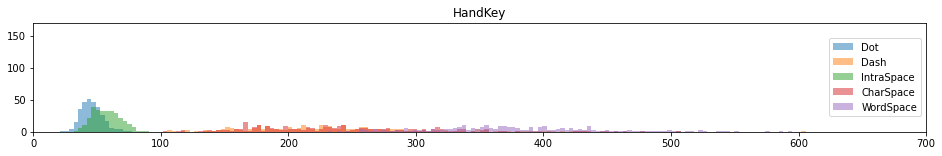

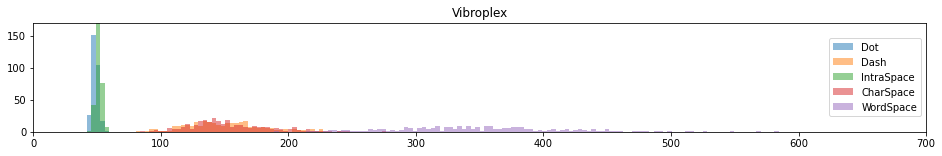

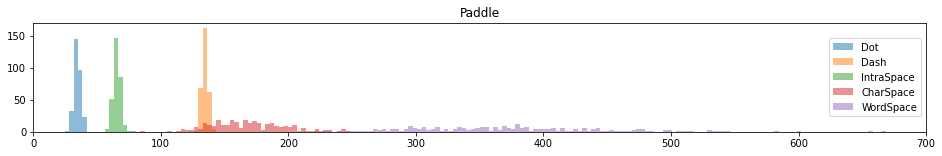

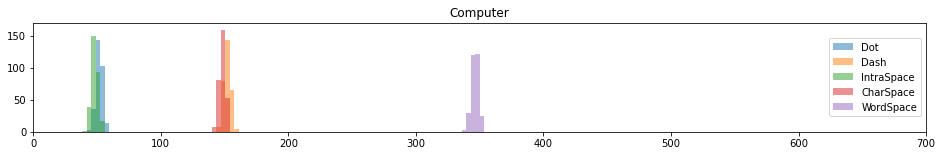

In [6]:
import keying_stats

for style in range(keying_stats.KeyingStyle.COUNT):
    stats = keying_stats.KeyingStats(24, style)
    plt.figure(figsize=(16, 2))
    plt.title(keying_stats.KeyingStyle(style).name)
    plt.axis([0, 700, 0, 170])
    for el in range(keying_stats.MorseElement.COUNT):
        lengths = [1000 * stats.get_length(el) for _ in range(300)]
        plt.hist(lengths, alpha = 0.5, bins = 200, range=(0,700), 
                 label=keying_stats.MorseElement(el).name)
        plt.legend(loc='right')
    plt.show()

### Keying waveform source
Generate the Morse keying waveform from the given message text, keep track of the character boundaries in the waveform.

In [7]:
%%writefile data_generation/keying_waveform.py
import numpy as np
import morse_code as mc
import text_generator as tg
import keying_stats as ks
    
# generates Morse keying waveform from random text
class MorseKeyingWaveform:
    def __init__(self, char_source, keying_stats, edge_ms, sampling_rate, continuous=True):
        self.keying_stats = keying_stats
        self.char_source = char_source
        self.sampling_rate = sampling_rate
        self.continuous = continuous
        
        # edges
        samples_per_edge = round(sampling_rate * edge_ms * 1e-3)
        raised_cosine = np.float32(np.hanning(2 * samples_per_edge + 1)[1:])
        self.front_edge = raised_cosine[:samples_per_edge]
        self.rear_edge = raised_cosine[-samples_per_edge:]

        # add some leading space
        self.reset()
        
    def get(self, count):
        available_count = len(self.waveforms[0])
        
        while available_count < count:
            char = self.char_source.__next__()
            char_waveform = self.get_char_waveform(char)
            self.waveforms.append(char_waveform)
            available_count += len(char_waveform)
            self.sample_count += len(char_waveform)
            self.chars[self.sample_count] = char
            
        # if last char does not fully fit
        if not self.continuous and self.sample_count > count: 
            self.waveforms[-1] = np.zeros(len(self.waveforms[-1]), dtype=np.float32)
            
        waveform = np.concatenate(self.waveforms).ravel()
        self.waveforms = [waveform[count:]]
        waveform = waveform[:count]
        
        chars = {pos: ch for pos, ch in self.chars.items() if pos < count}
        self.chars = {(pos - count): ch for pos, ch in self.chars.items() if pos >= count}      
        
        self.sample_count -= count
      
        if not self.continuous: self.reset()
    
        return waveform, chars
    
    # private
    def get_char_waveform(self, char):
        # word space, return zeros in addition to the last char space zeros
        if char == ' ':
            length = max(1, self.get_length(ks.MorseElement.WordSpace) - self.get_length(ks.MorseElement.CharSpace))
            return np.zeros(length, dtype=np.float32)

        code = mc.morse_codes[char]
        waveforms = []

        # morse elements of the char
        for c in code:            
            waveforms.append(self.front_edge)

            element = ks.MorseElement.Dot if c == '.' else ks.MorseElement.Dash
            length = self.get_length(element) - len(self.front_edge)
            waveforms.append(np.ones(length, dtype=np.float32))
                
            waveforms.append(self.rear_edge)
            
            length = self.get_length(ks.MorseElement.IntraSpace) - len(self.rear_edge)
            waveforms.append(np.zeros(length, dtype=np.float32))
                             
        # char space in addition to the last intra space
        length = max(1, self.get_length(ks.MorseElement.CharSpace) - self.get_length(ks.MorseElement.IntraSpace))
        waveforms.append(np.zeros(length, dtype=np.float32))
       
        return np.concatenate(waveforms)

    # private
    def reset(self):    
        count = round(self.keying_stats.get_length(ks.MorseElement.CharSpace) * self.sampling_rate)
        self.sample_count = count
        self.waveforms = [np.zeros(count, dtype=np.float32)]
        self.chars = {self.sample_count: ' '}

    #private
    def get_length(self, element):        
        return round(self.keying_stats.get_length(element) * self.sampling_rate)        

Writing data_generation/keying_waveform.py


### Validate waveform source
Plot a sample waveform, and mark the end of each character (including the charspace).

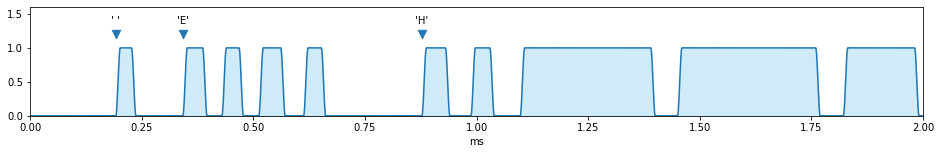

In [8]:
import text_generator as tg
import keying_stats as ks
import keying_waveform as kw

rate = 6000
wpm = 24
edge_ms = 10
seconds = 2 # show 2 seconds of waveform

char_source = tg.randomMorseTextGenerator()
keying_stats = ks.KeyingStats(wpm, ks.KeyingStyle.HandKey)    
gen = kw.MorseKeyingWaveform(char_source, keying_stats, edge_ms, rate)

data, chars = gen.get(seconds * rate)
f = np.linspace(0, seconds, len(data))

plt.figure(figsize=(16, 2))
plt.axis([0, seconds, 0, 1.6])
plt.fill_between(f, data, 0.00, color='skyblue', alpha=0.4)
plt.plot(f, data)

for pos, ch in chars.items():
    plt.annotate("'" + ch + "'", (pos / rate, 1.2), textcoords="offset points",                 
               xytext=(0,10), ha='center')

plt.scatter([c/rate for c in chars.keys()], (np.ones(len(chars)) * 1.2), marker='v', s=70)
plt.xlabel('ms')
plt.show()

### Bandlimited noise
Generate complex gaussian noise with a 500-Hz bandwidth, a typical bandwidth of an HF receiver in the CW mode.

In [9]:
%%writefile data_generation/noise.py
import numpy as np
from numpy.random import default_rng
from scipy import signal
import math

class BandlimitedGaussianNoiseSource:
    def __init__(self, bandwidth, order, sampling_rate):
        self.cutoff = bandwidth / sampling_rate
        self.rng = default_rng()
        self.sos = signal.butter(order, self.cutoff, output='sos')
        self.zi = signal.sosfilt_zi(self.sos)
        
        # prime
        self.get(round(sampling_rate / bandwidth))
        
    def get(self, count):
        wave = self.rng.normal(0, math.sqrt(1 / self.cutoff), count)
        wave, self.zi = signal.sosfilt(self.sos, wave, zi=self.zi)
        wave = wave.astype(np.float32) 
        return wave

class ComplexBandlimitedGaussianNoiseSource:
    def __init__(self, bandwidth, order, sampling_rate):
        self.re = BandlimitedGaussianNoiseSource(bandwidth, order, sampling_rate)
        self.im = BandlimitedGaussianNoiseSource(bandwidth, order, sampling_rate)

    def get(self, count):
        return 1j * self.im.get(count) + self.re.get(count) 
    
def complex_gaussian(amplitude, count):
    wave = 1j * amplitude * np.random.randn(count)
    wave += amplitude * np.random.randn(count)
    return wave.astype(np.complex64)
        

Writing data_generation/noise.py


### Validate noise source
Generate sample noise, compute its spectrum, verify the r.m.s. (should be sqrt(2))

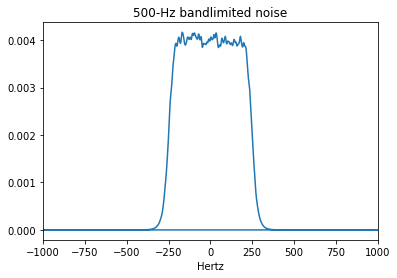

R.m.s. = 1.419093370437622


In [10]:
import noise as ns

bandwidth = 500
rate = 6000

# generate 5 min. of data
noise = ns.ComplexBandlimitedGaussianNoiseSource(bandwidth, 8, sampling_rate=rate)
data = noise.get(rate * 5*60)
rms = np.std(data)

# compute power spectrum
f, pwr = signal.periodogram(data, rate, return_onesided=False)
wing = len(pwr) // 2 
pwr = np.concatenate((pwr[-wing-1:-1], pwr[:wing]))
f = np.concatenate((f[-wing-1:-1], f[:wing]))

# smooth spectrum
sos = signal.butter(2, 0.2 / bandwidth, output='sos')
pwr = signal.sosfiltfilt(sos, pwr)

# plot spectrum
plt.xlim([-2*bandwidth, 2*bandwidth])
# plt.yscale('log')
plt.plot(f, pwr)
plt.title('500-Hz bandlimited noise')
plt.xlabel('Hertz')
plt.show()

print("R.m.s. = {}".format(rms))

### Rayleigh fading
Generate the Rayleigh fading (gain as a function of time). Doppler spread defines the speed of amplitude change.

In [11]:
%%writefile data_generation/fading.py
from numpy.random import default_rng
import math
import noise as ns

class RayleighFading:
    def __init__(self, doppler_spread, sampling_rate):
        self.doppler_spread = doppler_spread
        self.gain = ns.ComplexBandlimitedGaussianNoiseSource(1.25 * doppler_spread, 2, sampling_rate)

    def get(self, count):
        return 0.946 * self.gain.get(count)

Writing data_generation/fading.py


### Validate Rayleigh fading waveform
Generate sample Rayleigh fading data. Plot the gain vs. time, plot the amplitude drift on the complex plane.

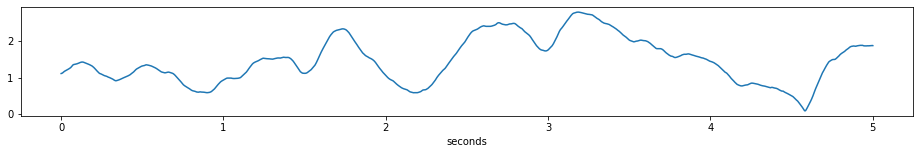

Rms = 1.5669169425964355


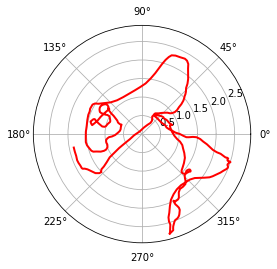

In [12]:
import fading as fd

rate = 6000
bandwidth = 1

# generate 5 s of data
fading = fd.RayleighFading(bandwidth, rate)      
complex_data = fading.get(5 * rate)
rms = np.std(complex_data)
real_data = abs(complex_data)

# plot vs time
plt.figure(figsize=(16, 2))
plt.plot(np.linspace(0, 5, len(real_data)), real_data)
plt.xlabel('seconds')
plt.show()
print("Rms = {}".format(rms))

# plot on complex plane
complex_data = complex_data[::100]
r = abs(complex_data)
theta = np.angle(complex_data)
ax = plt.subplot(111,projection='polar')
ax.plot(theta,r,color='r',linewidth=2)
# ax.scatter(theta,r,color='r')
ax.grid(True)
plt.show()


### Validate Rayleigh fading spectrum
Compute and plot the spectrum of sample Rayleigh fading data. According to the Watterson ionospheric propagation model, the spectrum should have Gaussian shape.

1 hour of data generated in 1.7249970436096191 s


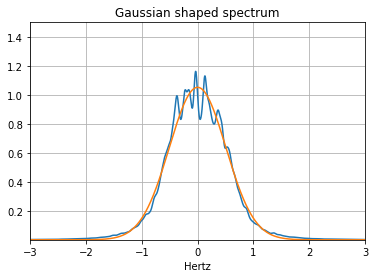

Two-sigma bandwidth = 1.0116072476270135 Hz


In [13]:
import fading as fd

rate = 6000   
bandwidth = 1 # Hz

# generate data
fading = fd.RayleighFading(bandwidth, rate)      
start_time = time.time()
data = fading.get(3600 * rate)
end_time = time.time()
print("1 hour of data generated in {} s".format(end_time - start_time))

# compute power spectrum
f, pwr = signal.periodogram(data, rate, return_onesided=False)
wing = len(pwr) * 20 // rate
pwr = np.concatenate((pwr[-wing-1:-1], pwr[:wing]))
f = np.concatenate((f[-wing-1:-1], f[:wing]))

# smooth spectrum
b, a = signal.butter(3, 0.005 / bandwidth)
pwr = signal.filtfilt(b,a, pwr)
pwr /= pwr[wing]

# plot spectrum
plt.title('Gaussian shaped spectrum')
plt.xlabel('Hertz')
plt.xlim([-3*bandwidth, 3*bandwidth])
plt.ylim(1e-6, 1.5)
# plt.yscale('log')
plt.grid(True)
plt.plot(f, pwr)

# fit gaussian
def func(x, a, s): return a * np.exp(-x*x/(2*s*s))
popt, pcov = curve_fit(func, f, pwr)
plt.plot(f, func(f, *popt))
plt.show()

print("Two-sigma bandwidth = {} Hz".format(2 * popt[1]))

### Morse audio source
Generate CW audio using the keying waveform and noise generated with the code above.

In [14]:
%%writefile data_generation/audio_source.py
import numpy as np
from numpy.random import default_rng
import noise as ns

def amplitude_from_db(x): return 10 ** (x / 20)

class MorseAudioSource:
    def __init__(self, keyer, fading, noise_floor, snr, pitch, pitch_error=0):
        self.keyer = keyer
        self.fading = fading
        self.amplitude = amplitude_from_db(noise_floor + snr)
        self.noise_rms = amplitude_from_db(noise_floor)       
        
        self.pitch = pitch
        self.pitch_error = pitch_error
        self.omega = 2 * np.pi * (pitch + pitch_error) / keyer.sampling_rate
        self.phi = 0
        self.rng = default_rng()

    
    def get(self, count):
        # signal
        keying, chars = self.keyer.get(count)
        
        # fading
        audio = keying * self.amplitude
        if self.fading != None: audio = self.fading.get(count) * audio
        
        # noise
        audio = ns.complex_gaussian(self.noise_rms, count) + audio

        # mix up to pitch
        if self.omega > 0:
            phase = self.omega * np.linspace(0, count, count, dtype=np.float32) + self.phi
            self.phi = phase[-1] + self.omega # starting phase in the next block
            audio *= np.exp(1j*phase)    
        
        audio = np.real(audio)
        keying[0] = np.round(keying[0])        
        return audio, keying, chars
    
    def get_noise(self, count):
        audio = ns.complex_gaussian(self.noise_rms, count)

        # mix up to pitch
        if self.omega > 0:
            phase = self.omega * np.linspace(0, count, count, dtype=np.float32) + self.phi
            self.phi = phase[-1] + self.omega # starting phase in the next block
            audio *= np.exp(1j*phase)    
        
        return np.real(audio)        

Writing data_generation/audio_source.py


### Validate audio source
Generate sample CW audio, plot the data

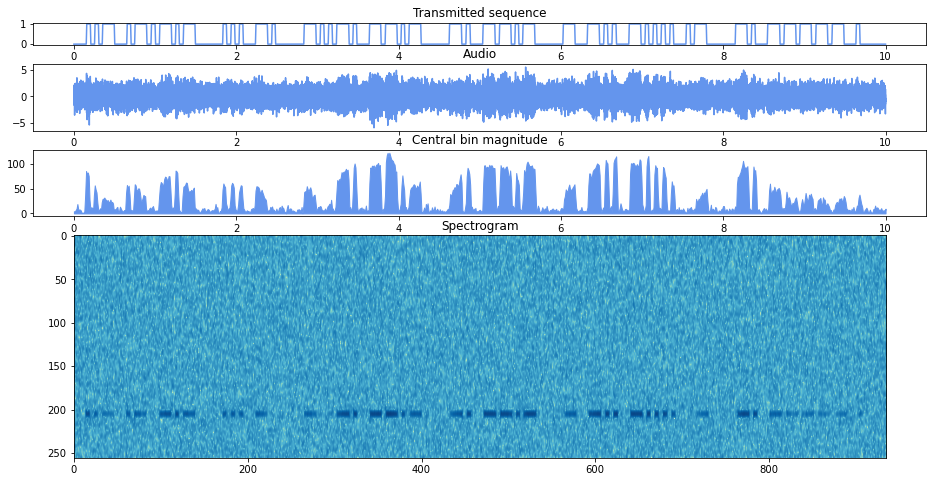

In [15]:
import tensorflow as tf
import text_generator as tg
import keying_stats as ks
import fading as fd
import keying_waveform as wf
import audio_source as au

rate = 6000
snr = 0 # dB
wpm = 24
doppler_spread = 1 # Hz
pitch = 600 # Hz
noise_floor = 0 # dBFS
seconds = 10

char_source = tg.randomMorseTextGenerator()
keying_stats = ks.KeyingStats(wpm, ks.KeyingStyle.Computer)    
keyer = wf.MorseKeyingWaveform(char_source, keying_stats, 5, rate, False)
if doppler_spread > 0:
    fading = fd.RayleighFading(doppler_spread, rate)      
else:
    fading = None
        
audio_source = au.MorseAudioSource(keyer, fading, noise_floor, snr, pitch)


# generate 5 seconds of Morse audio
audio, keying, _ = audio_source.get(seconds * rate)

# 5 seconds of data to plot 
spectrogram = tf.signal.stft(audio, fft_length=512, frame_step=64, frame_length=180)[:,-1:0:-1]
bin_magnitude = np.abs(spectrogram[:,256-51])
spectrogram_db = np.log(abs(spectrogram)).T

# plot
fig, ax = plt.subplots(nrows=4, gridspec_kw={'height_ratios': [0.5, 1.5, 1.5, 5]})
fig.set_figwidth(16) 
fig.set_figheight(8)

f = np.linspace(0, seconds, len(keying))
ax[0].plot(f, keying, 0, color='cornflowerblue')
ax[0].set_title('Transmitted sequence')

f = np.linspace(0, seconds, len(audio))
ax[1].plot(f, audio, 0, color='cornflowerblue')
ax[1].set_title('Audio')

f = np.linspace(0, seconds, len(bin_magnitude))
ax[2].fill_between(f, bin_magnitude, 0, color='cornflowerblue')
ax[2].set_title('Central bin magnitude')

f = np.linspace(0, seconds, len(spectrogram_db))
ax[3].imshow(spectrogram_db, cmap='GnBu')
plt.title('Spectrogram')

plt.show()

# play back
ipd.Audio(audio, rate=rate)

### Validate SNR
Verify the r.m.s. of noise and keying waveform

In [16]:
import fading as fd
import audio_source as au

rate = 6000
pitch = 600 # Hz
doppler_spread = 1 # Hz

class ContinuousTone:
    def __init__(self, sampling_rate):
        self.sampling_rate = sampling_rate        
    def get(self, count):
        return np.ones(count), {}
    
keyer = ContinuousTone(rate)
fading = fd.RayleighFading(doppler_spread, rate)      

# noise only, must be 1.0
noise_floor = 0
snr = -100
source = au.MorseAudioSource(keyer, fading, noise_floor, snr, pitch)
wave, _, _ = source.get(rate * 100)
noise_rms = np.sqrt(np.mean(wave**2))
print(f'noise_rms: {noise_rms}')

# signal only, must be 1.0
noise_floor = -100
snr = 100 
source = au.MorseAudioSource(keyer, fading, noise_floor, snr, pitch)
wave, _, _ = source.get(rate * 3000)
amplitude = np.sqrt(np.mean(wave**2))
print(f'amplitude: {amplitude}')

noise_rms: 0.9991295791495024
amplitude: 0.9928771573188232


### Morse spectrogram source
Generate a spectrogram from the CW audio

In [17]:
%%writefile data_generation/spectrogram_source.py
import numpy as np
import tensorflow as tf
import functools

def rect_window(window_length, beta=12.0, dtype=tf.dtypes.float32, name=None):
    return tf.ones(window_length, dtype=dtype)

class MorseSpectrogramSource:
    def __init__(self, audio_source, frame_step, fft_length, bin_count, window_function_length):
        self.fft_length = fft_length    
        self.window_function_length = window_function_length
        self.frame_step = frame_step 
        self.bin_count = bin_count 

        self.audio_source = audio_source
        self.audio_buffer, self.keying_buffer, self.chars = audio_source.get(self.window_function_length - self.frame_step)
        # TODO: find best beta
        self.window_fn=functools.partial(tf.signal.kaiser_window, beta=6)
        # self.window_fn=rect_window
        
    def get(self, count):
        # get audio
        audio, keying, chars = self.audio_source.get(self.frame_step * count)
        
        # push to buffer
        audio = np.concatenate((self.audio_buffer, audio))
        self.audio_buffer = audio[-len(self.audio_buffer):]
        
        keying, self.keying_buffer = np.concatenate((self.keying_buffer, keying)), keying[-len(self.keying_buffer):]

        # sfft
        spectra = tf.signal.stft(audio, fft_length=self.fft_length, frame_length=self.window_function_length, 
                                 frame_step=self.frame_step, window_fn=self.window_fn)
        
        # get strip around pitch
        central_bin = round(self.audio_source.pitch * self.fft_length / self.audio_source.keyer.sampling_rate)
        central_bin = max(central_bin, self.bin_count//2)
        spectra = spectra[:, central_bin-self.bin_count//2 : central_bin+self.bin_count//2]      
        spectra = tf.abs(spectra)        
        
        # downsample keying waveform
        keying = np.round(keying[self.window_function_length // 2 :: self.frame_step])
        chars = {(pos // self.frame_step): ch for pos, ch in chars.items()}   
        
        #debug!
        self.last_audio = audio

        return spectra, keying, chars

Writing data_generation/spectrogram_source.py


### Validate spectrogram source
Generate and plot sample spectrogram and corresponding message characters.


spectra: (187, 16), keying: (187,)
SNR: 6 dB, QSB: 1 Hz, WPM: 48


{6: ' ', 33: 'D', 69: 'K', 90: 'T', 112: 'T', 135: 'T', 166: 'A'}


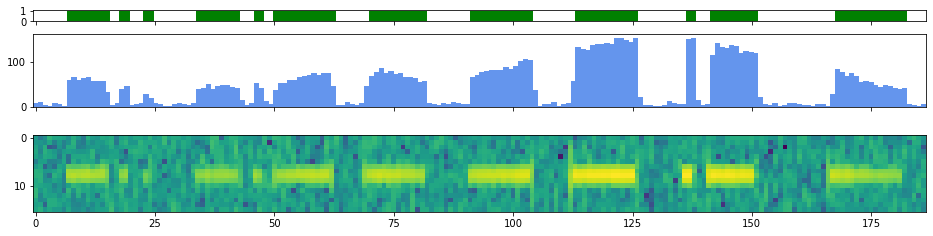



{1: 'T', 30: 'D', 62: 'M', 93: 'U', 101: ' ', 148: 'O', 159: ' '}


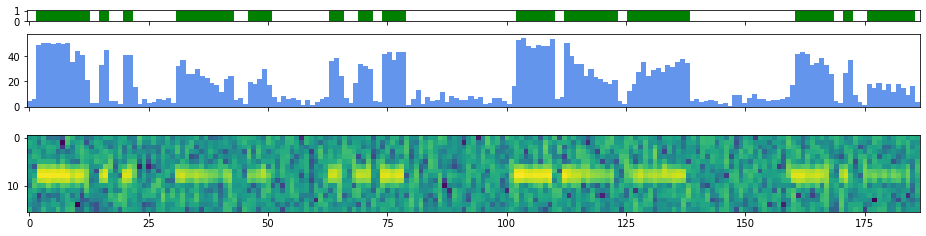

In [18]:
import text_generator as tg
import keying_stats as ks
import fading as fd
import keying_waveform as wf
import audio_source as au
import spectrogram_source as ss

rate = 6000
snr = 6 # dB
wpm = 48
doppler_spread = 1 # Hz
pitch = 600 # Hz
noise_floor = 0 # dBFS
bin_count = 16
frame_step = 64
fft_size = 128
window_function_length = 90

# allow chars to be split between the blocks
countiunos = True

char_source = tg.randomMorseTextGenerator()
keying_stats = ks.KeyingStats(wpm, ks.KeyingStyle.HandKey)    
keyer = wf.MorseKeyingWaveform(char_source, keying_stats, 1, rate, countiunos)
fading = fd.RayleighFading(doppler_spread, rate)      
audio_source = au.MorseAudioSource(keyer, fading, noise_floor, snr, pitch)
spect_source = ss.MorseSpectrogramSource(audio_source, frame_step, fft_size, bin_count, window_function_length)


# check shapes
spectra, keying, chars = spect_source.get(round(2 * rate // frame_step))
print("\nspectra: {}, keying: {}".format(spectra.shape, keying.shape))
print("SNR: {} dB, QSB: {} Hz, WPM: {}\n\n".format(snr, doppler_spread, wpm))
print(chars)

# visualize
f = np.linspace(0, len(spectra), len(spectra))
spectrogram_db = np.transpose(np.log(abs(spectra)))        
bin_magnitude = np.abs(spectra[:, bin_count//2])

fig, ax = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [0.3, 2, 3]})
fig.set_figwidth(16) 
fig.set_figheight(4)
ax[0].bar(f, keying, color='green', width=1.1)
ax[1].bar(f, bin_magnitude, color='cornflowerblue', width=1.1)
ax[2].imshow(spectrogram_db, interpolation='none')
plt.show()


spectra, keying, chars = spect_source.get(round(2 * rate // frame_step))
spectrogram_db = np.transpose(np.log(abs(spectra)))        
bin_magnitude = np.abs(spectra[:, bin_count//2])
print('\n')
print(chars)
fig, ax = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [0.3, 2, 3]})
fig.set_figwidth(16) 
fig.set_figheight(4)
ax[0].bar(f, keying, color='green', width=1.1)
ax[1].bar(f, bin_magnitude, color='cornflowerblue', width=1.1)
ax[2].imshow(spectrogram_db, interpolation='none')
plt.show()


### Generation Speed test
Measure the speed of data generation and time spent at each generation step.

In [19]:
import time
import text_generator as tg
import keying_stats as ks
import fading as fd
import keying_waveform as wf
import audio_source as au
import spectrogram_source as ss
    
rate = 6000
snr = 6 # dB
wpm = 24
doppler_spread = 1 # Hz
noise_floor = 0 # dBFS
countiunos = True
bin_count = 16
frame_step = 64
fft_length = 128

# set to 0 to improve speed if not intended for listening 
pitch = 600 # Hz

samples_per_hour = rate * 3600 
spectra_per_hour = samples_per_hour // frame_step

char_source = tg.randomMorseTextGenerator()
keying_stats = ks.KeyingStats(wpm, ks.KeyingStyle.Computer)    
keying_source = wf.MorseKeyingWaveform(char_source, keying_stats, 5, rate, countiunos)
fading_source = fd.RayleighFading(doppler_spread, rate)      
audio_source = au.MorseAudioSource(keying_source, fading_source, noise_floor, snr, pitch)
spect_source = ss.MorseSpectrogramSource(audio_source, frame_step, fft_length,                                                  
                                         bin_count, window_function_length)
print("Time to generate 1 hour of data:")

start_time = time.time()
keying_source.get(samples_per_hour)
end_time = time.time(); 
print("   keying: {} seconds".format((end_time - start_time)))

start_time = time.time()
fading_source.get(samples_per_hour)
end_time = time.time(); 
print("   fading: {} seconds".format((end_time - start_time)))

start_time = time.time()
audio_source.get(samples_per_hour)
end_time = time.time(); 
print("   audio: {} seconds".format((end_time - start_time)))

start_time = time.time()
spectra, _, chars = spect_source.get(spectra_per_hour)
end_time = time.time(); 
print("   spectra: {} seconds".format((end_time - start_time)))
print("      spctra shape: {}".format(spectra.shape))
print(f'      measured WPM: {len(chars) / 60 / 6}')

start_time = time.time()
block_size = 256
block_count = spectra_per_hour // block_size
for _ in range(block_count):
    spectra, _, _ = spect_source.get(block_size)
end_time = time.time(); 
print("   spectra in blocks: {} seconds".format((end_time - start_time)))
print("      block count: {}, shape: {}".format(block_count, spectra.shape))


Time to generate 1 hour of data:
   keying: 1.1009931564331055 seconds
   fading: 2.107999801635742 seconds
   audio: 7.601001977920532 seconds
   spectra: 11.500576734542847 seconds
      spctra shape: (337500, 16)
      measured WPM: 23.258333333333336
   spectra in blocks: 19.209551572799683 seconds
      block count: 1318, shape: (256, 16)


### Morse Data Generator
Putting it all togehter: the class that produces batches of spectrograms using all classes defined above. The spectrograms may be continuous, when the characters are allowed to cross the spectrogram boundaries, or self-contained, when each character is fully contained in one spectrogram.

The message parameters (SNR, keying speed, etc.) may be optionally changed at specified intervals.

The `MorseDataGenerator` class is used to generate training and testing data on the fly during the deep model training and validation.

In [26]:
%%writefile data_generation/morse_data_generator.py
import tensorflow as tf
import numpy as np
import sys
import text_generator as tg
import keying_stats as ks
import fading as fd
import keying_waveform as wf
import audio_source as au
import spectrogram_source as ss
import random


class MorseDataGenerator:

#-------------------------------------------------------------------------------------------------------------
#                                            public methods
#-------------------------------------------------------------------------------------------------------------
    def __init__(self, settings):
        self._initialize(settings)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.get()
    
    def __call__(self):
        self._reset()
        while True:
            try:            
                yield self.get()                
            except StopIteration:
                return
            
    def get(self):
        # count generated batches
        self.batch_countdown -= 1
        if self.batch_countdown < 0:
             raise StopIteration         
        
        # randomize settings every (randomize_every_batches) batches
        if self.randomize_countdown == 0:
            self.sources = np.array([self._make_spectrogram_source() for _ in range(self.batch_size)])
            if self.overlap_margin > 0:
                self.overlap = [s.get(2 * self.overlap_margin) for s in self.sources]   
            self.randomize_countdown = self.randomize_every_batches

        # no chars should cross block boundary in the last batch, even if continuous=true
        elif self.randomize_countdown == 1:
            for s in self.sources:
                s.audio_source.keyer.continuous = False

        # make a batch    
        batch = self._format_batch(self._make_batch())
        self.randomize_countdown -= 1
        return batch
    

#-------------------------------------------------------------------------------------------------------------
#                                            private methods
#-------------------------------------------------------------------------------------------------------------
    def _initialize(self, settings):
        self.initial_settings = {**self.get_default_settings(), **settings}
        
        self.settings = self.initial_settings.copy()        
        self.spectrogram_width = self.settings.pop('spectrogram_width')
        self.spectrogram_height = self.settings.pop('spectrogram_height')
        self.batch_size = self.settings.pop('batch_size')
        self.batch_count = self.settings.pop('batch_count')
        self.randomize_every_batches = self.settings.pop('randomize_every_batches', sys.maxsize)
        self.overlap_margin = self.settings.pop('overlap_margin')
        
        self._reset()
        
    def _reset(self):
            self.randomize_countdown = 0
            self.batch_countdown = self.batch_count
            self.overlap = None

    @classmethod
    def get_default_settings(cls):
        'Returns default settings as a dict'
        return {    
            'wpm': 24,            
            'snr': 50,
            'doppler_spread': 1,
            'continuous': False,
            'noise_floor': 0,
            'pitch': 1500,
            'pitch_error': 0,
            'keying_style': ks.KeyingStyle.Computer,

            'edge_ms': 2,
            'sampling_rate': 6000,
            'fft_length': 512,
            'window_function_length': 200,
            'frame_step': 64,
            'spectrogram_width': 256,
            'spectrogram_height': 16,
            'overlap_margin': 0,
            'batch_size': 4,
            'batch_count': 330 # (sampling_rate * 3600) / (frame_step * spectrogram_width * batch_size)
        }  
    
    
    def _get_random_settings(self):
        'Selects random values for the settings that are specified as ranges or lists'
        result = self.settings.copy()
        for key in result.keys():
            if isinstance(result[key], dict):
                result[key] = np.random.uniform(result[key]['low'], result[key]['high'])
            elif isinstance(result[key], list):
                result[key] = random.choices(result[key][0], result[key][1])[0]
                
        return result    
    
    
    def _make_spectrogram_source(self):
        'Creates a MorseSpectrogramSource object with given settings'    
        self.current_settings = self._get_random_settings()   

        char_source = tg.randomMorseTextGenerator()    
        keying_stats = ks.KeyingStats(self.current_settings['wpm'], self.current_settings['keying_style'])    

        keyer = wf.MorseKeyingWaveform( 
            char_source = char_source, 
            keying_stats = keying_stats, 
            edge_ms = self.current_settings['edge_ms'],
            sampling_rate = self.current_settings['sampling_rate'], 
            continuous = self.current_settings['continuous']
        )

        if self.current_settings['doppler_spread'] > 0: 
            fading = fd.RayleighFading(self.current_settings['doppler_spread'], self.current_settings['sampling_rate'])
        else:
            fading = None            

        audio_source = au.MorseAudioSource(
            keyer, 
            fading, 
            self.current_settings['noise_floor'], 
            self.current_settings['snr'], 
            pitch=self.current_settings['pitch'] if self.current_settings['pitch'] != None else self.current_settings['sampling_rate'] / 4, 
            pitch_error=self.current_settings['pitch_error']
        )

        spectrogram_source = ss.MorseSpectrogramSource(
            audio_source, 
            self.current_settings['frame_step'], 
            self.current_settings['fft_length'], 
            self.spectrogram_height, 
            self.current_settings['window_function_length'])

        return spectrogram_source

    
    # manipulate sparse array of chars and their positions {pos:ch}
    def _shift_indices(self, dictionary, delta):
        return {(pos + delta): ch for pos, ch in dictionary.items()}   
    
    def _select_range(self, dictionary, start_idx, end_idx):
        return {pos: ch for pos, ch in dictionary.items() if pos >= start_idx and pos < end_idx}   
        
        
    def _make_batch(self):
        'Generates a batch of data with overlapping'
        batch = [s.get(self.spectrogram_width) for s in self.sources]   

        if self.overlap_margin == 0:
            return batch
        
        for i in range(self.batch_size):        
            # get new data
            spectra, _, chars = batch[i]
            
            # concatenate with saved overlapping spectra
            spectra = np.concatenate((self.overlap[i][0], spectra), axis=0)
            overlapping_spectra = spectra[-2*self.overlap_margin:].copy()
            
            # merge with saved overlapping chars, excluding those in the margins   
            T = self.spectrogram_width
            M = self.overlap_margin
            
            # 0..2M
            overlapping_chars = self.overlap[i][2]            
            # ovl = -2M..0
            overlapping_chars = self._shift_indices(overlapping_chars, - 2 * M)
            # ovl = -2M..0 + 0..T
            chars = {** overlapping_chars, **chars}
            # ch = -M..T+M
            chars = self._shift_indices(chars, M)
            # ovl= T-M..T+M
            overlapping_chars = self._select_range(chars, T-M, T+M)
            # ovl = 0..2M
            overlapping_chars = self._shift_indices(overlapping_chars, -T+M)
            # ch = 0..T
            chars = self._select_range(chars, 0, T)
            
            self.overlap[i] = (overlapping_spectra, None, overlapping_chars)
            batch[i] = (spectra, None, chars)
    
        return batch

    
    def _format_batch(self, batch):
        'Normalizes and re-packages batch data'
        max_chars = max([len(b[2]) for b in batch])
        
        for i in range(self.batch_size):
            spectra, _, chars = batch[i] 
            
            # format spectrogram: normalize values, expand last dim            
            
            #spectra = np.log(spectra)
            #spectra = np.log(1 + spectra)
            #spectra = np.square(spectra)
            #spectra -= np.mean(spectra)
            spectra /= np.std(spectra, dtype=np.float32) * 4
            spectra = tf.expand_dims(spectra, axis=-1)

            # format chars: dict to padded array of nums
            chars = list(chars.values())        
            chars = tg.morse_char_to_num(chars) if len(chars) > 0 else []
            pad_count = max_chars - len(chars)
            chars = tf.pad(
                chars, 
                paddings=[[0,pad_count]], 
                constant_values=(tf.constant(tg.MORSE_ALPHABET_SIZE-1, dtype=tf.int64))
            )
            
            batch[i] = (spectra, chars)
            
        # array of tuples to tuple of arrays
        batch = ([b[0] for b in batch], [b[1] for b in batch])
        return batch

Overwriting data_generation/morse_data_generator.py


### Morse Dataset
A function that generates a TensorFlow dataset using the `MorseDataGenerator` class as data generator.

In [21]:
%%writefile data_generation/morse_dataset.py
import tensorflow as tf
import morse_data_generator as mg
        
def create_morse_dataset(settings):
    'Creates a TensorFlow.Dataset using MorseDataGenerator with given settings'
    
    # create generator
    generator = mg.MorseDataGenerator(settings)
    
    # define dataset structure
    total_spectrogram_width = generator.spectrogram_width + 2 * generator.overlap_margin
    spect_shape = (generator.batch_size, total_spectrogram_width, generator.spectrogram_height, 1)
    chars_shape = (generator.batch_size, None)
    signature = (tf.TensorSpec(shape=spect_shape, dtype=tf.float32), tf.TensorSpec(shape=chars_shape, dtype=tf.int64))
                
    # create dataset
    ds = tf.data.Dataset.from_generator(generator, output_signature=signature)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds                  

Writing data_generation/morse_dataset.py


### Validate dataset and save / load
Generate a Tensorflow dataset, save it to a file, load it back.

In [22]:
%%time
import tensorflow as tf
import tempfile
import shutil
import os
import morse_dataset as md

BATCH_SIZE = 2

settings = {
    'batch_size': BATCH_SIZE,
    'overlap_margin': 10,
    'batch_count': 2
}    

# create
morse_ds = md.create_morse_dataset(settings)
print(f"Created dataset: {morse_ds}")

# save
path = os.path.join(tempfile.gettempdir(), "saved_data")
print("Saving to {}".format(path))
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path, exist_ok=True)
tf.data.experimental.save(morse_ds, path)

# clear
spec = morse_ds.element_spec
morse_ds = None

# load
print("Load using spec: {}".format(spec))
morse_ds = tf.data.experimental.load(path, spec)
print(f"Loaded dataset: {morse_ds}")
print(f"Batches in loaded dataset: {len(list(morse_ds))}")
morse_ds = morse_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(f"Dataset after Prefetch: {morse_ds}\n")

Created dataset: <PrefetchDataset shapes: ((2, 276, 16, 1), (2, None)), types: (tf.float32, tf.int64)>
Saving to C:\Users\Alex\AppData\Local\Temp\saved_data
Load using spec: (TensorSpec(shape=(2, 276, 16, 1), dtype=tf.float32, name=None), TensorSpec(shape=(2, None), dtype=tf.int64, name=None))
Loaded dataset: <_LoadDataset shapes: ((2, 276, 16, 1), (2, None)), types: (tf.float32, tf.int64)>
Batches in loaded dataset: 2
Dataset after Prefetch: <PrefetchDataset shapes: ((2, 276, 16, 1), (2, None)), types: (tf.float32, tf.int64)>

Wall time: 283 ms


### View generated spectrograms
Plot some of the spectrograms in the dataset.

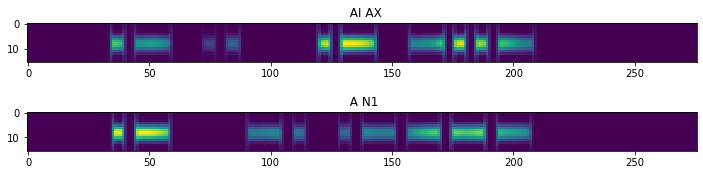

In [23]:
import text_generator as tg
fig, axes = plt.subplots(BATCH_SIZE, 1, figsize=(12, BATCH_SIZE * 1.5))

for batch in morse_ds.take(1):
    spectrograms = batch[0]
    targets = batch[1]
    
    for i in range(BATCH_SIZE):
        ax = axes[i]    
        ax.imshow(spectrograms[i][:,:,0].numpy().T, interpolation='none')
        ax.set_title(tg.num_to_morse_text(targets[i]))
plt.show()

### Spectra to .bin file

In [24]:
# generate spectra for testing C API code, and save to bin file
import training_settings as ts
import keying_stats as ks
import morse_data_generator as mg

var_settings = {  
    'wpm': 24, 
    'snr': 30, 
    'doppler_spread': 0,
    'keying_style': ks.KeyingStyle.Paddle,
    'pitch_error': 0,
    'noise_floor': 0,
    
    'spectrogram_width': 30*6000//64,
    'batch_size': 1,
    'batch_count': 1, 
    'randomize_every_batches': 1
}

test_settings = {**ts.training_settings, **var_settings}
print(f'Settings: {test_settings}\n')

batch = mg.MorseDataGenerator(test_settings).get()
batch[0][0].numpy().tofile('spectra.bin')
print(f'Message text: "{tg.num_to_morse_text(batch[1][0])}"')
# print(batch[0][0][-1])

Settings: {'snr': 30, 'wpm': 24, 'doppler_spread': 0, 'keying_style': <KeyingStyle.Paddle: 2>, 'pitch_error': 0, 'noise_floor': 0, 'frame_step': 64, 'window_function_length': 300, 'spectrogram_width': 2812, 'spectrogram_height': 22, 'overlap_margin': 3, 'continuous': True, 'fft_length': 512, 'batch_size': 1, 'batch_count': 1, 'randomize_every_batches': 1}

Message text: " 5WIN LFTEL WIP ES QL6O NT.LSE AM 4OEK K EFGL OS EOBT EA HW RHAR FR L"
